In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Импортируем нужные библиотеки

### Считываем данные, делаем их более удобными для работы

In [12]:
df = pd.read_excel("200_выпусков_'О_мой_питч!'_OutOfScope_update.xlsx", sheet_name='Лист2')
df = df.rename(columns={'Инвестиции' : 'Инвестиции(руб)', 'Без' : 'Воздержалось'})
df['За'] = pd.to_numeric(df['За'], errors='coerce')
df['Против'] = pd.to_numeric(df['Против'], errors='coerce')
df['Воздержалось'] = pd.to_numeric(df['Воздержалось'], errors='coerce')
df = df.drop(columns='№')
df = df.drop(index=82) #Дропаем строку в бизнесом, о котором нет данных
df = df.drop_duplicates(subset='Название')
pd.set_option('display.max_colwidth', None)  # 150 означает ограничение на кол-во символов в колонке "Описание"


Название                   object
Описание                   object
Сайт                       object
Инвестиции(руб)             int64
За                          int64
Против                      int64
Воздержалось              float64
Всего                       int64
Дата               datetime64[ns]
dtype: object

### Основные метрики по инвестициям и голосам в опросах

In [16]:
pd.options.display.float_format = '{:,.0f}'.format
df[['Инвестиции(руб)', 'За', 'Против', 'Воздержалось', 'Всего']].describe()

,Инвестиции(руб),За,Против,Воздержалось,Всего
count,196,196,196,134,196
mean,"48,356,674",149,204,134,445
std,"103,612,111",80,99,44,117
min,0,35,43,61,182
25%,"7,087,500",95,133,102,358
50%,"22,500,000",128,176,131,436
75%,"45,000,000",184,250,155,527
max,"900,000,000",519,535,385,735


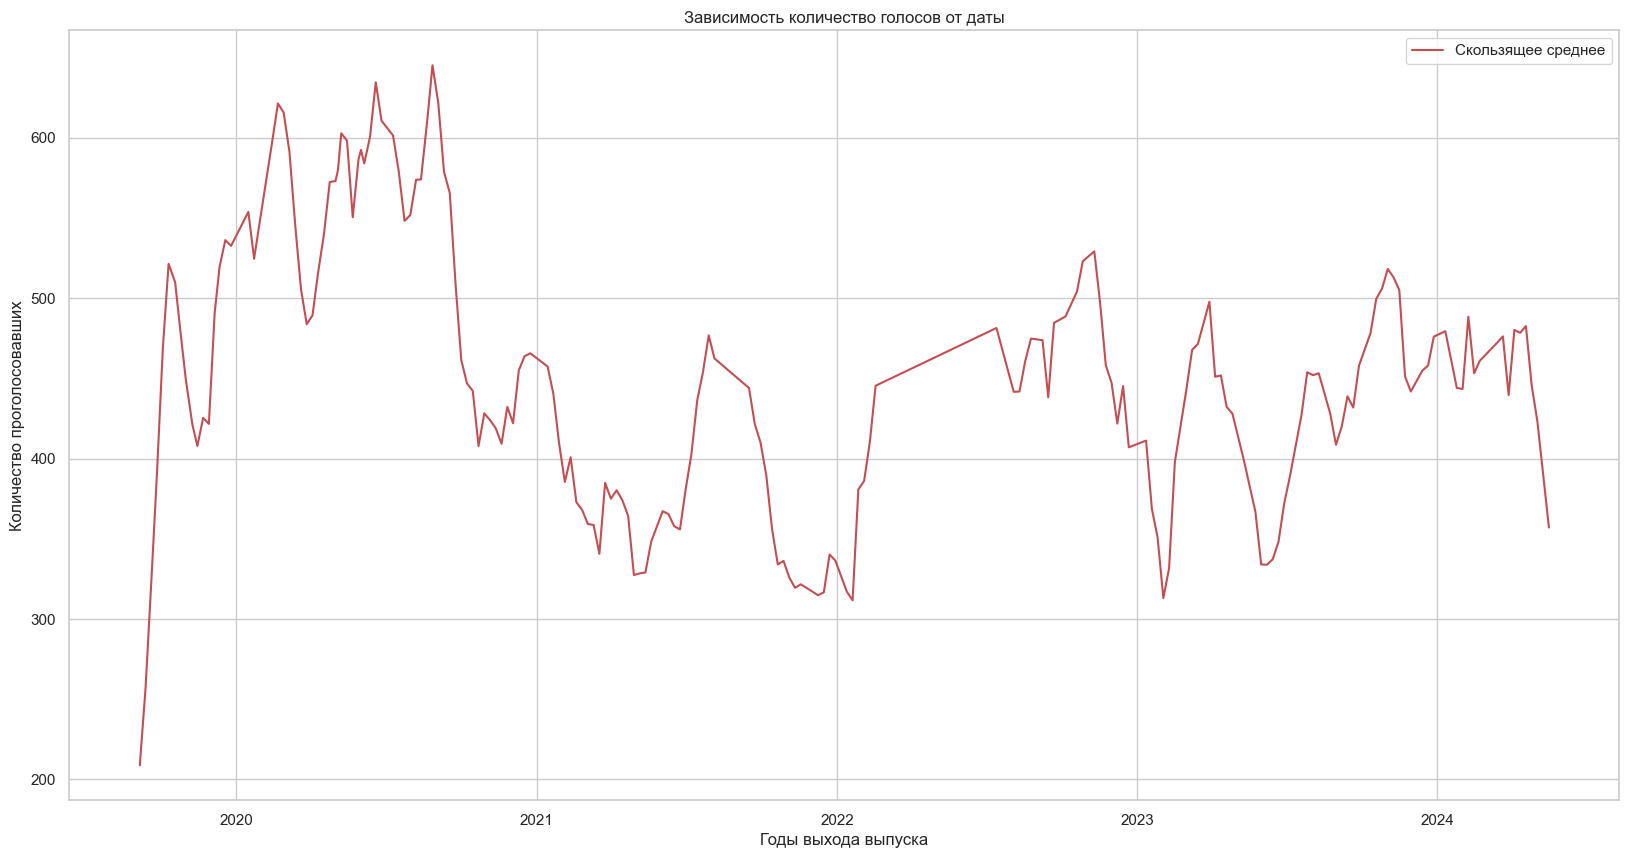

In [5]:
sns.set_theme(style='whitegrid')
plt.figure(figsize=(20, 10))

df['Всего_rolling'] = df['Всего'].rolling(window=5).mean()
sns.lineplot(x='Дата', y='Всего_rolling', data=df, color='r', label='Скользящее среднее')

plt.xlabel('Годы выхода выпуска')
plt.ylabel('Количество проголосовавших')
plt.title('Зависимость количество голосов от даты')
plt.show()




### Считаем скользящее среднее, чтобы уменьшить шум и нагляднее видеть выбросы

Из графика видно, что опросы стали проводиться примерно осенью 2019 года. Можно предположить, что выпуски начали выходить примерно в то же время.
Примерно за год количество голосов в опросах вырасло примерно в 3 раза и к осени 2020 года достигло своего локального максимума.
С 2021 года и по наше время количество проголосовавших колеблется примерно от 300 до 500 

In [6]:
keywords = {
    'IT': ['код', 'хак', 'it', 'ai', 'програм', 'кибер', 'искусствен', 'база', 'веб', 'web', 'аналитик', 'мобиль', 'приложен'],
    'Фрилансеры': ['фриланс', 'удален', 'самозанят'],
    'Бизнес' : ['бизнес', 'цен', 'маркетинг', 'бренд', 'аналитик', 'seo', 'smm', 'management'],
    'Медицина' : ['диагностик ', 'профилактик', 'медицин', 'врач', 'докт', 'хирург ', 'операц', 'маломобильных', 'процедур','здоровь'],
    'Студенчество': ['студент', 'университет', 'школ', 'образован', 'универ', 'экзамен', 'курс', 'общежит'],
    
    'Музыка': ['музык', 'песн', 'звук', 'аккорд', 'мелод'],
    'Спорт': ['тренировк', 'фитнес', 'физкультур', 'атлетик', 'кардио', 'нагруз', 'сорев', 'экипиров'],
    
    
    'Транспорт_и_доставка': ['ремонт', 'машина', 'техобслуж', 'кузов', 'запчаст', 'транспорт', 'курьер', 'доставк'],
    'Поездки_и_путешествия': ['поездк', 'туризм', 'путешеств', 'путевк', 'экскурси', 'курорт', 'проживание'],
    'Кулинария': ['кухн', 'повар', 'еда', 'пищ', 'рецепт', 'ингредиент', 'блюд'],
    
    
}

def categorize(description):
    matched_categories = []
    words_in_description = description.lower().split()  # Разбиваем описание на слова
    
    for category, words in keywords.items():
        if any(any(word.startswith(keyword) for keyword in words) for word in words_in_description):
            matched_categories.append(category)
            
    return ', '.join(matched_categories) if matched_categories else 'Прочее'

# Пример датафрейма
df['Категория'] = df['Описание'].apply(categorize)

# Вывести результат
df['Категория'].unique()

array(['Бизнес', 'IT, Медицина', 'IT, Бизнес', 'IT, Транспорт_и_доставка',
       'Бизнес, Транспорт_и_доставка', 'IT', 'Транспорт_и_доставка',
       'Прочее', 'Бизнес, Медицина', 'Медицина', 'Музыка',
       'IT, Бизнес, Студенчество', 'Студенчество', 'IT, Спорт',
       'IT, Бизнес, Поездки_и_путешествия', 'Фрилансеры',
       'IT, Бизнес, Транспорт_и_доставка', 'Кулинария',
       'Поездки_и_путешествия',
       'Бизнес, Медицина, Транспорт_и_доставка, Кулинария',
       'Бизнес, Студенчество', 'IT, Бизнес, Медицина',
       'IT, Поездки_и_путешествия', 'IT, Студенчество', 'Спорт',
       'Медицина, Студенчество, Спорт', 'IT, Медицина, Спорт',
       'Бизнес, Кулинария'], dtype=object)

### Разбивка стартапов по группам

Для разбивки используются ключевые слова, которые наиболее подходят для выбраной категории. Слова выбирались по принципу запроса "топ-10 слов на тему "нужная тема", затем был проведен осмотр на наличие и удаление общих слов (слов с общими корнями, по типу "авто"), также переработан подход к парсингу: теперь слова в описании должны НАЧИНАТЬСЯ с ключевых слов, а не просто содержать корни в любом месте слова. После этого был проведен вторичный осмотр на "откровенно" ложные данные. Поскольку изначально не стоит задача идеально распределить все стартапы, а лишь раздеить их "условные" группы, основываясь на вторичную проверку, а также на получившиеся графики, можно сделать вывод о том, что IT - как и ожидалось, имеет наибольшую долю



In [11]:
# Функция для разбиения категорий
def explode_categories(df):
    df_exploded = df.assign(Категория=df['Категория'].str.split(', ')).explode('Категория')
    return df_exploded

# Функция для выбора случайного стартапа в каждой категории
def get_random_startup_by_category(df, columns_to_display):
    # Проверка на наличие всех столбцов в DataFrame
    missing_columns = [col for col in columns_to_display if col not in df.columns]
    if missing_columns:
        raise ValueError(f"Следующие столбцы отсутствуют в DataFrame: {missing_columns}")
    
    random_startups = []
    grouped = df.groupby('Категория')  # Группируем по категории
    
    for category, group in grouped:
        random_startup = group.sample(1)  # Выбираем 1 случайный стартап из группы
        random_startups.append(random_startup)
    
    # Соединяем результаты в один DataFrame
    result_df = pd.concat(random_startups)
    
    # Отображаем только нужные столбцы
    return result_df[columns_to_display]

# Пример вызова
columns_to_display = ['Название', 'Описание', 'Категория']
df_exploded = explode_categories(df)  # Предполагаем, что df определён
random_startups_df = get_random_startup_by_category(df_exploded, columns_to_display)

random_startups_df

,Название,Описание,Категория
178,ACYD App,"Нейросетевой видеоредактор ACYD. Если кратко, то парни сделали приложение, которое с помощью нейросетей обрабатывает ваше видео под разные художественные стили, а вы потом красивенькое видео постите себе в сторис в Instagram. Совсем грубо — это Prisma для видео.",IT
147,Sapien Wallet,"Мы разработали рейтинговую систему (рейтинг человека), основанную на весе транзакций. Например, Мария рассчиталась с Иваном, и они могут поставить друг другу рейтинг о сотрудничестве. Чтобы показать, как все работает, зашили в приложение легкого криптовалютного кошелька, ну и допилили классный интерфейс. Мы выложим приложение в течении месяца в магазины (UPD: уже есть для Android) и нам нужны деньги для доработки и привлечения скачек. Свои деньги - 212к$ - успешно потратили в течении года на разрабов, дизайн и маркетинг",Бизнес
100,Qummy,"Роботизация приготовления еды для HoReCa (без поваров и кухни на 2 кв.м). Наши клиенты - РЖД, Газпром, Кухня на районе. 140 клиентов, 31% рост месяц к месяцу по выручке. Участники Alchemist",Кулинария
197,Azura AI,"Azura AI разрабатывает сервис для поддержания и профилактики здоровья, который:\n— хранит и автоматически собирает медицинские данные пользователя, в том числе и с фитнес-трекеров,\n— предоставляет персональные рекомендации по улучшению здоровья,\n— предсказывает вероятности возникновения заболеваний.\n\nРабота сервиса основана на применении искусственного интеллекта. В команде Azure AI есть и специалисты по ИИ, и врачи.",Медицина
35,Everysong,"Это маркетплейс по продаже песен. Как Amazon, Ozon или Wildberries, но только с песнями. Проект соединяет авторов с артистами, забирая на себя составление и обслуживание каталога песен, а также организацию финансового и юридического сопровождения. Наша цель адаптировать и развить этот проект под мировой рынок, чтобы соединять сонграйтеров и исполнителей во всех странах.",Музыка
113,Taxibus,"Taxibus генерирует новый формат дешевой для пассажира и выгодной для перевозчика поездки. Используя ИИ, сервис формирует групповые поездки из отдельных трансферов. Остановки и маршруты автобусов задают сами пассажиры.",Поездки_и_путешествия
8,Metacraft,"Metacraft — Многопользовательская онлайн-игра в жанре научной фантастики. Игра запущена в раннем доступе: можно зарегистрироваться и поиграть (ОС Windows). После привлечения первого раунда запланирован выход на платформы VKplay и Steam, а также выход на международный рынок. Есть подтвержденный спрос. В первый месяц после запуска проекта, на очень ранней стадии, нам удалось заработать более 200 тыс. рублей и привлечь большое количество игроков без затрат на рекламу",Прочее
42,FitMind.ai,"AI-ассистент для онлайн тренеров по фитнесу и велнесу, который помогает им качественнее отвечать на вопросы клиентов и экономить время",Спорт
167,Trillions,"Высокотехнологичная платформа для трейдеров и инвесторов. Дает доступ из единого окна ко всем крупнейшим биржам, включая криптовалютные. Торговые сервера размещены в соседних стойках с серверами бирж, есть FIX API для профессионалов.\n\nТакже проект предлагает цифровую альтернативу классического банкинга, только с обменом активов по биржевому курсу и без какой-либо наценки. Крипто-френдли. P2P-переводы по номеру телефона и моментальное пополнение любой карты в два клика.\n\nУ основателей уже есть опыт создания и продажи успешного финтех-стартапа.",Студенчество
3,WINEST,"Winest — cервис по доставке вина с технологией AI-сомелье. Технология диджитал-сомелье показала кратно больший средний чек по сравнению с конкурентами. Сервис гарантирует, что клиенту понравится вино, а если не понравится — вернут деньги. Уже продали 2000+ бутылок, получили 0 возвратов. Сейчас Winest продает вино онлайн с доставкой за 60 минут в Израиле, а после привлечения раунда хотят выйти на рынок Германии. Фаундер — Игорь Подстрешный, (http://t.me/ipodster) основатель московской сети Burger Heroes, ресторана Дом Культур и Рюмочной мечты",Транспорт_и_доставка


### Функции, которые выводят датафрейм со случайными бизнесами из каждой категории

In [8]:
# Функция для подсчета всех категорий, содержащих подкатегорию
def count_subcategory_occurrences(df, subcategories):
    # Разделение категорий на отдельные строки
    categories = df['Категория'].str.split(', ', expand=True)
    categories = categories.melt(value_name='Категория').dropna()['Категория']
    
    # Подсчет всех категорий, содержащих каждую подкатегорию из списка
    results = {}
    for subcategory in subcategories:
        count = categories[categories.str.contains(subcategory, case=True)].count()
        results[subcategory] = count
    
    # Сортировка по убыванию значений
    sorted_results = dict(sorted(results.items(), key=lambda item: item[1], reverse=True))
    
    return sorted_results

# Список подкатегорий, которые нужно проверить
subcategories_list = ['Прочее', 'IT', 'Бизнес', 'Музыка', 'Фрилансеры', 'Медицина', 'Спорт', 'Транспорт_и_доставка', 'Поездки_и_путешествия', 'Кулинария', 'Студенчество']

# Подсчет количества всех категорий для каждой подкатегории в списке
subcategory_counts = count_subcategory_occurrences(df, subcategories_list)
subcategory_counts


{'IT': np.int64(69),
 'Прочее': np.int64(67),
 'Бизнес': np.int64(43),
 'Медицина': np.int64(17),
 'Транспорт_и_доставка': np.int64(16),
 'Поездки_и_путешествия': np.int64(8),
 'Студенчество': np.int64(8),
 'Кулинария': np.int64(6),
 'Спорт': np.int64(4),
 'Музыка': np.int64(2),
 'Фрилансеры': np.int64(1)}

### Группируем получившиеся данные по уникальным комбинациям категорий, сортируем по убыванию для выявления наиболее популярных категорий

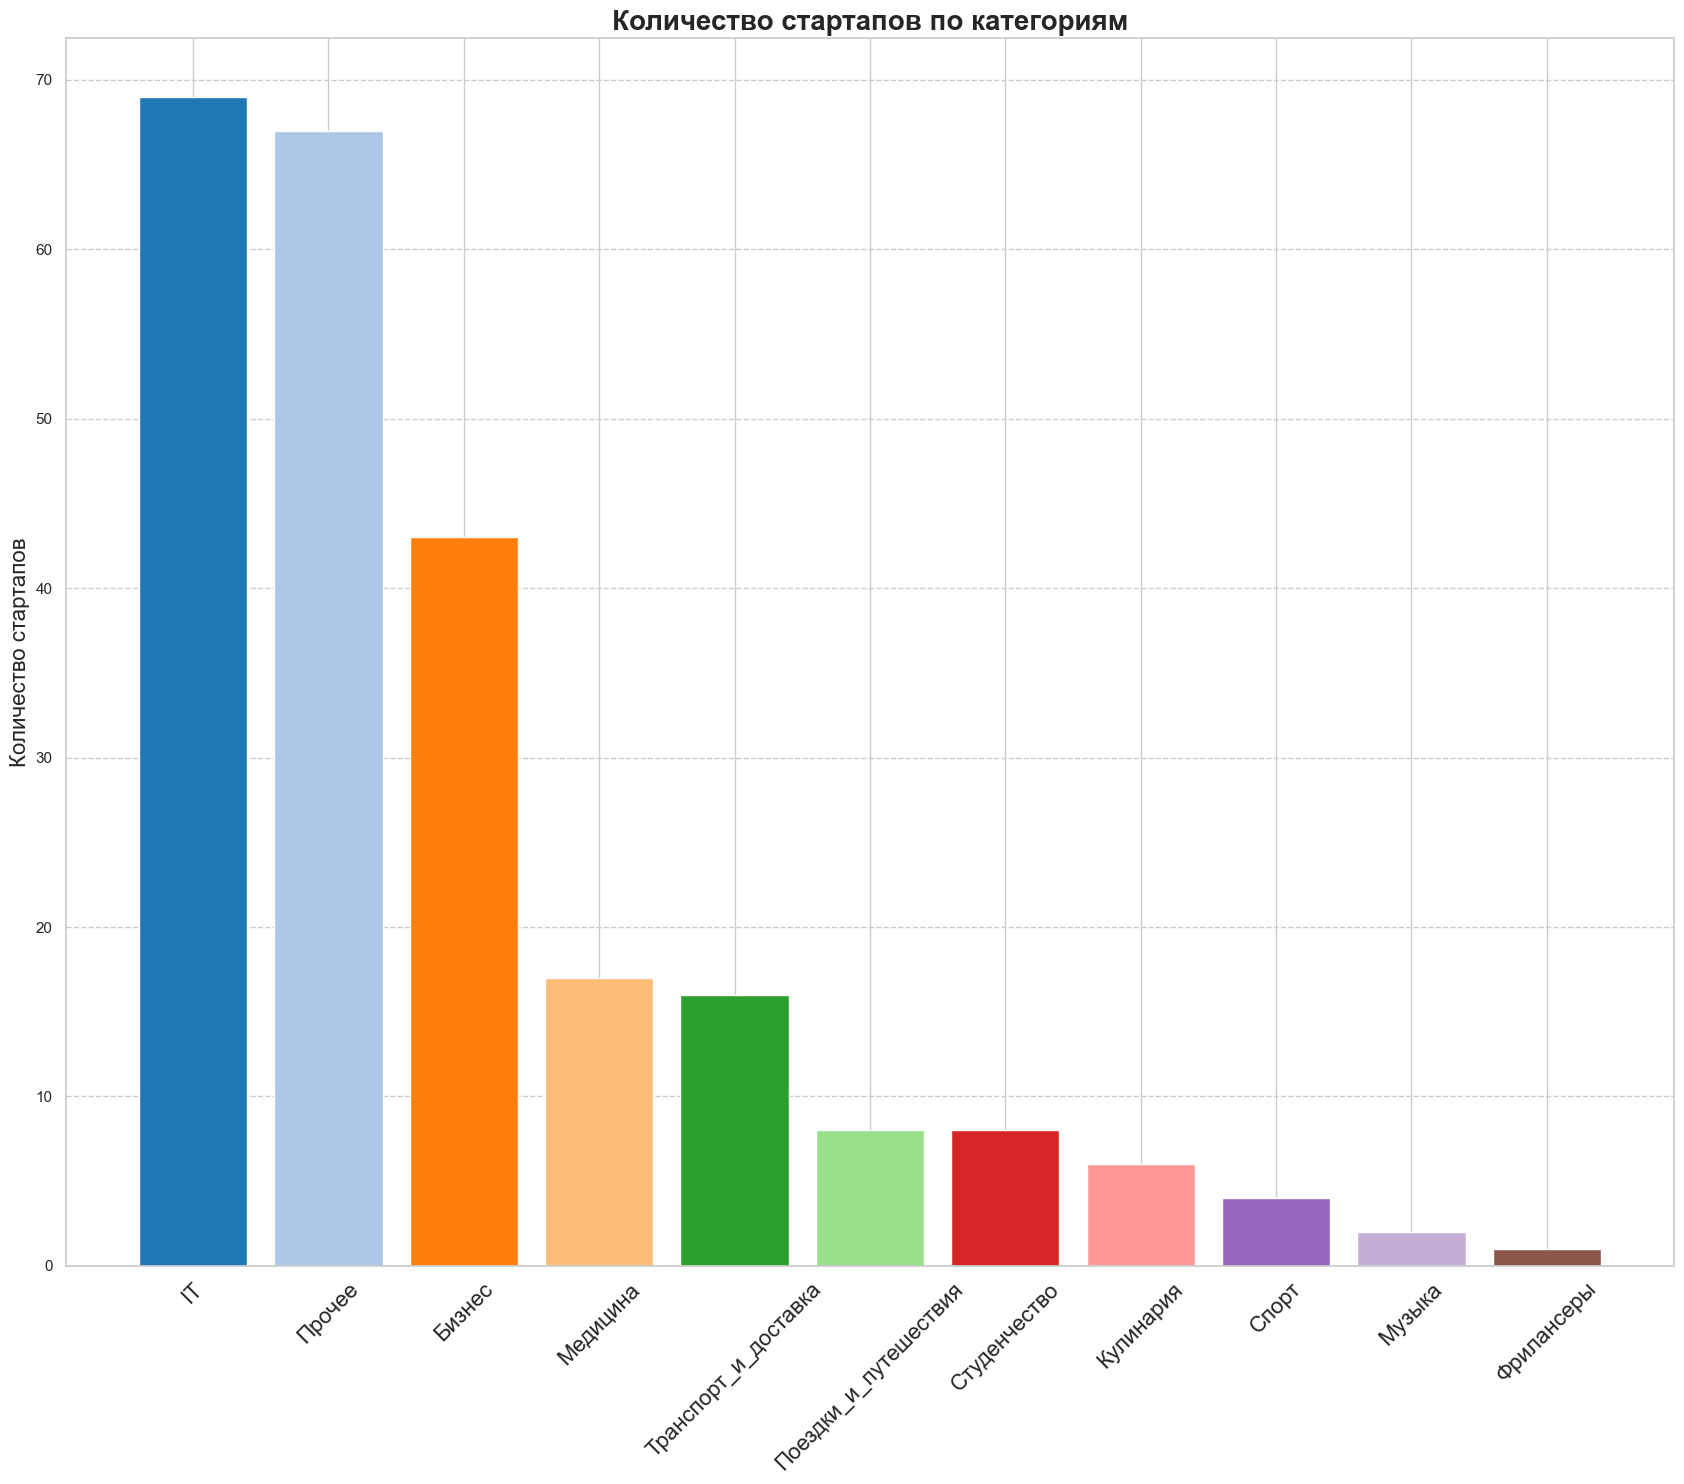

In [9]:
category_labels = list(subcategory_counts.keys())
category_counts = list(subcategory_counts.values())



colors = plt.get_cmap('tab20').colors

plt.figure(figsize=(17, 15))
plt.bar(
    category_labels, 
    category_counts, 
    color=colors[:len(category_labels)]  # Убедитесь, что достаточно цветов для всех категорий
)

plt.title('Количество стартапов по категориям', fontsize=20, fontweight='bold')
plt.ylabel('Количество стартапов', fontsize=16)
plt.xticks(rotation=45, fontsize=16)  # Поворот меток категорий, если они длинные
plt.grid(axis='y', linestyle='--')  # Сетка по вертикальной оси
plt.tight_layout()  # Подгонка для отображения меток
plt.show()

### Визуализируем данные для большей наглядности

Видим, что распределение по заданным (предполагаемым) группам в основном сосредоточилось на бизнес и IT проектках

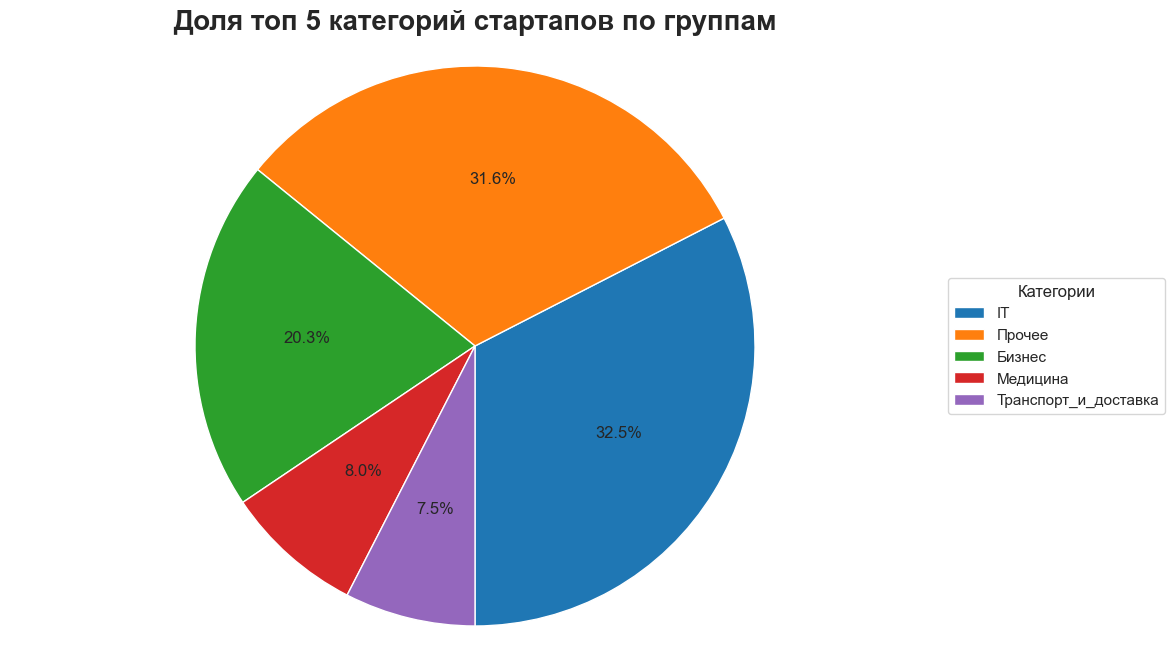

In [10]:

merge_to_other = ['Спорт', 'Музыка', 'Фрилансеры', 'Кулинария', 'Поездки_и_путешествия', 'Студенчество']

category_labels = list(subcategory_counts.keys())
category_counts = list(subcategory_counts.values())
other_count = 0

# Создаем новые списки для обновления
for label, count in zip(category_labels, category_counts):
    if label in merge_to_other:
        other_count += count  # Суммируем категории, которые пойдут в "Прочее"

# Удаляем объединенные категории из исходных списков
category_labels = [label for label in category_labels if label not in merge_to_other]
category_counts = [count for label, count in zip(category_labels, category_counts) if label not in merge_to_other]

# Определение цветов для каждого сегмента
colors = plt.get_cmap('tab10').colors

# Создание круговой диаграммы с объединением в "Прочее"
plt.figure(figsize=(12, 8))
plt.pie(
    category_counts,
    autopct='%1.1f%%', 
    colors=colors[:len(category_labels)],  # Убедитесь, что достаточно цветов для всех категорий
    startangle=-90
)

# Настройка легенды
plt.legend(
    category_labels,
    title="Категории",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

plt.title('Доля топ 5 категорий стартапов по группам', fontsize=20, fontweight='bold')
plt.axis('equal')  # Оформление диаграммы в круг
plt.show()

### Визуализируем данные для большей наглядности

Заметим, что суммарно категории IT и бизнес содержат больше половины всех проектов из исходных данных (52.8%)

Также стоит отметить, что почти треть всех проектов либо не попала ни в одну из категорий, либо же процент от общего числа составлял меньше 5 %